In [15]:
!pip install opencv-python pyproj lxml rasterio shapely einops

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [11]:
!pip install --upgrade jupyterlab ipympl

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 9.2 MB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 511 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 35.3 MB/s eta 0:00:01
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 3.6.1
    Uninstalling jupyterlab-3.6.1:
      Successfully uninstalled jupyterlab-3.6.1


In [1]:
!python scripts/OLI2MSI/convert2png.py

total imgs: 5225
processing... 1/5225
processing... 2/5225
processing... 3/5225
processing... 4/5225
processing... 5/5225
processing... 6/5225
processing... 7/5225
processing... 8/5225
processing... 9/5225
processing... 10/5225
processing... 11/5225
processing... 12/5225
processing... 13/5225
processing... 14/5225
processing... 15/5225
processing... 16/5225
processing... 17/5225
processing... 18/5225
processing... 19/5225
processing... 20/5225
processing... 21/5225
processing... 22/5225
processing... 23/5225
processing... 24/5225
processing... 25/5225
processing... 26/5225
processing... 27/5225
processing... 28/5225
processing... 29/5225
processing... 30/5225
processing... 31/5225
processing... 32/5225
processing... 33/5225
processing... 34/5225
processing... 35/5225
processing... 36/5225
processing... 37/5225
processing... 38/5225
processing... 39/5225
processing... 40/5225
processing... 41/5225
processing... 42/5225
processing... 43/5225
processing... 44/5225
processing... 45/5225
pr

In [2]:
%ls

LICENSE    dataset/             saved_model_weights/  wavemixsr/
README.md  preprocessing.ipynb  scripts/


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.functional import interpolate
import PIL.Image as Image
import torchvision.transforms as transforms
from torchinfo import summary
import torchmetrics
from datasets import load_dataset
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

import wavemix
import kornia
import os
from einops import rearrange

from wavemix import Level1Waveblock

In [40]:
img_path = os.path.join('dataset/train_hr_png', os.listdir('dataset/train_hr_png/')[0])
print(img_path)
image = Image.open(img_path)

if image.mode == "L":
  image = image.convert('RGB')


transform = transforms.Compose([
    transforms.PILToTensor()
])

image = transform(image).float()/255.0
image = image.unsqueeze(0)

dataset/train_hr_png/L8_126038_20190923_S2B_20190923_T49RCQ_N0035.png


In [41]:
image_lr = interpolate(image, size=160, mode='bicubic').clamp(min=0, max=255)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 4090', major=8, minor=9, total_memory=24217MB, multi_processor_count=128)


In [67]:
class WaveMix(nn.Module):
    def __init__(
        self,
        *,
        depth,
        mult = 1,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.3,
    ):
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(Level1Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))

        self.final = nn.Sequential(
            nn.Conv2d(final_dim,int(final_dim/2), 3, stride=1, padding=1),
            nn.Conv2d(int(final_dim/2), 1, 1)
        )


        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=3, mode='bilinear', align_corners = False),
            nn.Conv2d(1, int(final_dim/2), 3, 1, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 1, 1)
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=3, mode='bilinear', align_corners = False),
            # nn.ConvTranspose2d(2, 2, 2, stride = 2)
        )

    def forward(self, img):

        y = img[:, 0:1, :, :]
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)


        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)

        return  torch.cat((y,crcb), dim=1)

model = WaveMix(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.3
)

model.to(device)
summary(model, input_size=(1, 3, 160, 160), col_names= ("input_size","output_size","num_params","mult_adds"), depth = 4)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
WaveMix                                       [1, 3, 160, 160]          [1, 3, 480, 480]          --                        --
├─Sequential: 1-1                             [1, 1, 160, 160]          [1, 144, 480, 480]        --                        --
│    └─Upsample: 2-1                          [1, 1, 160, 160]          [1, 1, 480, 480]          --                        --
│    └─Conv2d: 2-2                            [1, 1, 480, 480]          [1, 72, 480, 480]         720                       165,888,000
│    └─Conv2d: 2-3                            [1, 72, 480, 480]         [1, 144, 480, 480]        93,456                    21,532,262,400
├─ModuleList: 1-2                             --                        --                        --                        --
│    └─Level1Waveblock: 2-4                   [1, 144, 480, 480]        [1, 144, 48

In [68]:
path =  'Set5_3x_y_Div2k_psnr.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [82]:
output = model(image_lr.to(device))
# output = kornia.color.ycbcr_to_rgb(output)
output.shape

torch.Size([1, 3, 480, 480])

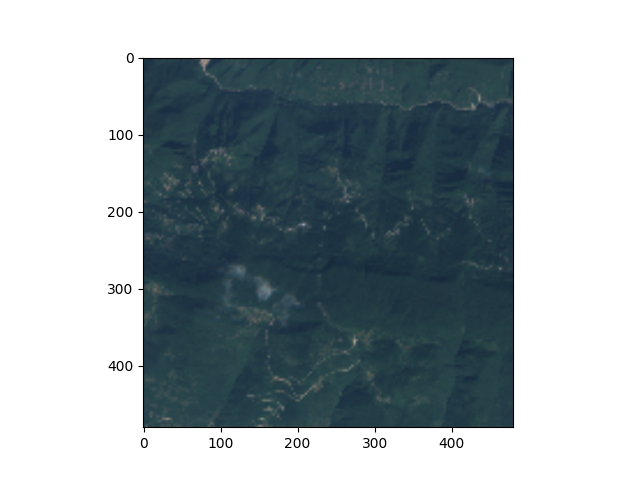

In [84]:
%matplotlib widget
from matplotlib import pyplot as plt


plt.imshow(rearrange(output.cpu().detach(), 'b c h w -> b h w c').squeeze(0))
# plt.imshow(rearrange(image_lr, 'b c h w -> b h w c').squeeze(0))
plt.show()

In [76]:
plt

<module 'matplotlib.pyplot' from '/root/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [86]:
from torchvision.utils import save_image
save_image(output.cpu().detach(), 'output.png')

In [88]:
save_image(image_lr, 'input.png')

In [1]:
!python scripts/OLI2MSI/bicubic_downsampling.py

0/5225
1/5225
2/5225
3/5225
4/5225
5/5225
6/5225
7/5225
8/5225
9/5225
10/5225
11/5225
12/5225
13/5225
14/5225
15/5225
16/5225
17/5225
18/5225
19/5225
20/5225
21/5225
22/5225
23/5225
24/5225
25/5225
26/5225
27/5225
28/5225
29/5225
30/5225
31/5225
32/5225
33/5225
34/5225
35/5225
36/5225
37/5225
38/5225
39/5225
40/5225
41/5225
42/5225
43/5225
44/5225
45/5225
46/5225
47/5225
48/5225
49/5225
50/5225
51/5225
52/5225
53/5225
54/5225
55/5225
56/5225
57/5225
58/5225
59/5225
60/5225
61/5225
62/5225
63/5225
64/5225
65/5225
66/5225
67/5225
68/5225
69/5225
70/5225
71/5225
72/5225
73/5225
74/5225
75/5225
76/5225
77/5225
78/5225
79/5225
80/5225
81/5225
82/5225
83/5225
84/5225
85/5225
86/5225
87/5225
88/5225
89/5225
90/5225
91/5225
92/5225
93/5225
94/5225
95/5225
96/5225
97/5225
98/5225
99/5225
100/5225
101/5225
102/5225
103/5225
104/5225
105/5225
106/5225
107/5225
108/5225
109/5225
110/5225
111/5225
112/5225
113/5225
114/5225
115/5225
116/5225
117/5225
118/5225
119/5225
120/5225
121/5225
122/5225
123

In [2]:
from random import sample

In [3]:
sample(range(5), 4)

[0, 3, 1, 4]

In [24]:
!python wavemixsr/train_bicubic_refined_loss.py -x 3

DeviceInfo:
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4090', major=8, minor=9, total_memory=24217MB, multi_processor_count=128)
Train Set Len: 5225
Val Set Len: 100
Test Set Len: 5225
Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
WaveMixSR                                     [1, 3, 160, 160]          [1, 3, 480, 480]          --                        --
├─Sequential: 1-1                             [1, 1, 160, 160]          [1, 144, 480, 480]        --                        --
│    └─Upsample: 2-1                          [1, 1, 160, 160]          [1, 1, 480, 480]          --                        --
│    └─Conv2d: 2-2                            [1, 1, 480, 480]          [1, 72, 480, 480]         720                       165,888,000
│    └─Conv2d: 2-3                            [1, 72, 480, 480]         [1, 144, 480, 480]        93,456                    21,532,262,400
├─ModuleList: 1-2    

In [26]:
import glob

In [31]:
glob.glob(os.path.join('dataset/', '*')) 

['dataset/train_hr',
 'dataset/train_hr_png',
 'dataset/train_lr_png',
 'dataset/train_hr.rar']